# Final Models Evaluation with Wild Fire Data

This notebooks will tune and run 3-4  classifiers on wildfire dataset in order to make a predecction on fire intensity. ExtraTrees, RandomForest, KNeighborsClassifier and Adaboost (optional).

This will be a binary classification, predict moderate to severe fires.
Original goal was to predict 4 categories but the classifiers and lack of data on Severe fires 
made predictions not reliable. 

In [24]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [25]:
#optional code to ensure everyone is on the right version
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.23.1.


# Import all the models and libraries needed

In [26]:
%matplotlib inline

import config as cg

import os
import pickle
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import config as cf

from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import LinearSVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import CVScores
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport

from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as smotePipeline





### Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally
Read a random sample.

Optimal training data is 100K - 200K - all the data we have to testin with to retain a good 4:1 ratio is 109K

link to databases:
https://drive.google.com/drive/folders/1UbAw16_GX1X1nSCy0f2vvCIqDTG7RP2Y?usp=sharing

In [27]:
df_train = pd.read_csv('data/train.csv').sample(109988)

print(df_train.shape)

(109988, 12)


### Assess data in the file. 
Check data to ensure it's correct.


In [28]:
# Expanding number of columns:
pd.set_option('display.max_columns', 30)

In [29]:
# review datagram
df_train.head() 


,latitude,longitude,doy,fuelcode,fuel_moisture_class,prefire_fuel,temperature,humidity,precip_intensity,wind_gust,wind_speed,fire_intensity_twocat
67914,43.0093,-118.4346,274,1180,2,2368.004874,84.65,0.14,0.0,6.24,2.24,Moderate
64366,43.1616,-118.2996,198,2,1,108.835506,86.01,0.16,0.0,20.85,12.66,Moderate
45962,31.2822,-93.2615,222,1140,2,7646.952224,99.58,0.61,0.0,8.65,3.56,Moderate
49247,30.3006,-91.2698,312,1,3,192.675834,69.09,0.65,0.0,7.70,5.39,Moderate
88286,34.1217,-81.8102,289,1400,2,6849.442774,72.43,0.68,0.0,4.28,0.97,Moderate


In [30]:
df_train.columns

Index(['latitude', 'longitude', 'doy', 'fuelcode', 'fuel_moisture_class',
       'prefire_fuel', 'temperature', 'humidity', 'precip_intensity',
       'wind_gust', 'wind_speed', 'fire_intensity_twocat'],
      dtype='object')

### Shape shows imbalanced data. We will under sample later to balance the data.

In [31]:
#show the shape of the data
print(df_train['fire_intensity_twocat'].value_counts())

Moderate    96035
Severe      13953
Name: fire_intensity_twocat, dtype: int64


### Setup the features for the pipeline

In [32]:
def find_X_y(df_fires1):

    features = ['latitude', 'longitude', 'doy','fuelcode', 'fuel_moisture_class', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'wind_gust',
                'wind_speed']

    # four categories using balanced binning
    #target = ['fire_intensity_fourcat']
    target = ['fire_intensity_twocat']
    
    y = df_fires1[target]
    y = np.ravel(y)
    Z = df_fires1[features]
    
    # Not really needed already 1-4 numerical
    #y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
    
    return Z, y


# Define the models to test
<b>Down to our best 2 </b>
RandomForest and ExtraTrees. Bagging and AdaBoost are optional given time. 
Set the parameters from the hyperparameter evaluation (works best for
precision)
defaults seems to work better for recall for severe which is our goal.

In [33]:
models = [     
            ExtraTreesClassifier(n_estimators=10, bootstrap=True, n_jobs=-1),
            #ExtraTreesClassifier(bootstrap=True, max_depth=10, n_jobs=-1, oob_score=True),
            RandomForestClassifier(n_estimators=10, bootstrap=True, n_jobs=-1),
            KNeighborsClassifier(p= 2),
            #RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1,
                       #oob_score=True),
            #BaggingClassifier( max_features=1, max_samples=1,
                  #n_estimators=5, n_jobs=-1, oob_score=True), 
            #BaggingClassifier(n_estimators=10), 
            #LinearSVC(),
            #SGDClassifier(),
            #GaussianNB(),
            #AdaBoostClassifier()
            #AdaBoostClassifier(n_estimators=10)
        ]    


### Data Imbalance
We have a massive data imbalanced, tried a combination or oversampling, undersampling and both combined.
Undersampling produced the best results with a lil bit over oversampling. Still imbalance but much less after
undersampling. Going with a 4:1 ratio of Moderate to Severe fires.

In [34]:
def smote_data(X, y):
    
    over_sample = {'Severe': 20000}
    over = SMOTE(sampling_strategy = over_sample)
    X, y = over.fit_resample(X,y)
    
    #previously undersample Moderate with new function in Save Train Test note book
    #under_range = {'Moderate': 120000} #recommend hyperparameter range - 150-200k
    #under = RandomUnderSampler(sampling_strategy=under_range)
    #X, y = under.fit_resample(X,y)
    
    return X, y

# Function to Fit and predict the scores of the model. 
Give us traning scores

In [35]:
def setup_model(X, y, estimator, **kwargs):
   
    #define category features to be one hot encoded
    cat_features = ['fuelcode', 'fuel_moisture_class']
     
    #define numeric features for scaling
    num_features = ['longitude', 'latitude', 'doy', 'prefire_fuel', 'temperature', 'humidity', 'precip_intensity', 'wind_gust', 'wind_speed']
    
    
    #round numeric values to two places after decimal
    round_transformer = FunctionTransformer(cg.round_lat_long)

    #setup simple one hot encoder
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent'))])

    #setup basic scaler
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler()),
        ('imputer', SimpleImputer(strategy='median'))])
    
    
    # Setting the transformation for the pipeline below. 
    preprocessor = ColumnTransformer (transformers=[
        ('num_features', numeric_transformer, num_features),
        ('cat_features', categorical_transformer, cat_features)])
    
   
    #setup the pipeline
    model = Pipeline(steps=[
          ('rounder', round_transformer),
          ('preprocessor', preprocessor),
          ('estimator', estimator)
         ])
    
    return model


### Test model against test data (no smote sythenic data)

In [36]:
def test_score(X_test, y_test, estimator):

    #testing against note smote dataset
    expected = y_test
    predicted = estimator.predict(X_test)

    print("")
     # Compute and return F1 harmonic mean and average
    print("{}: {}".format(estimator.__class__.__name__ + " : Original data F1 Micro Score ", f1_score(expected, predicted, average='micro')))
    print("{}: {}".format(estimator.__class__.__name__ + " : Original data F2 Macro Score ", f1_score(expected, predicted, average='macro')))
    
    
    print(classification_report(expected, predicted))

### Class Prediction Error

In [37]:

def class_pred_error(X_test, y_test, estimator):

    classes=['Moderate', 'Severe']

    visualizer = ClassPredictionError(
        estimator, 
        classes=classes, size=(400, 400)
    )
    
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data

    visualizer.show()



###  Print the classifcation report

In [38]:
def visualize_model_report(X_train, X_test, y_train, y_test, estimator, **kwargs):

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        estimator,
        classes=['Moderate', 'Severe'], # Classes for equal balanced bins per quartiles
        cmap="Reds", 
        support=True,
        size=(400, 400)
    )


    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data

    visualizer.show()
    
   
    


### Print the confusion matrix

In [39]:
def confusion_matrix_report (X_test, y_test, estimator, **kwargs):

    
    # The ConfusionMatrix visualizer taxes a model
    cm = ConfusionMatrix(estimator, classes=['Moderate','Severe'])


    # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
    # and then creates the confusion_matrix from scikit-learn.
    cm.score(X_test, y_test)

    cm.show()
    
 


### Show the ROCAUC Curve

In [40]:
def roc_curve (X_test, y_test, estimator):

    # Instantiate the classification model and visualizer
    classes=['Moderate', 'Severe']
    visualizer = ROCAUC(estimator, classes=classes, size=(400, 400))
                                           
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Draw the data


### Get the X,y to test frp, tje data frame

In [41]:
X, y = find_X_y(df_train)

In [42]:
collections.Counter(y)

Counter({'Moderate': 96035, 'Severe': 13953})

### Create more balanced data classes with smote

In [43]:
X, y = smote_data(X,y)

In [44]:
collections.Counter(y)

Counter({'Moderate': 96035, 'Severe': 20000})

### Setup the training and testing data

In [45]:
# Create the train and test data
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)


### Train the classifier ExtraTrees / Randomforest performed the same as ExtraTrees will move for with Trees only.
Resuts are the classifier has high recall and precision with moderate classes.
After several congifuratios Severe fires have lower recall and precision in the. 6 range.


###### TRAINING SCORES ExtraTrees ######


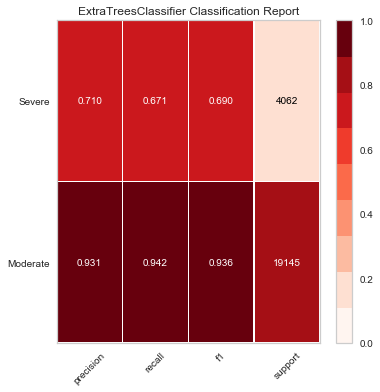


Pipeline : Original data F1 Micro Score : 0.8944714956694101
Pipeline : Original data F2 Macro Score : 0.813225158756063
              precision    recall  f1-score   support

    Moderate       0.93      0.94      0.94     19145
      Severe       0.71      0.67      0.69      4062

    accuracy                           0.89     23207
   macro avg       0.82      0.81      0.81     23207
weighted avg       0.89      0.89      0.89     23207



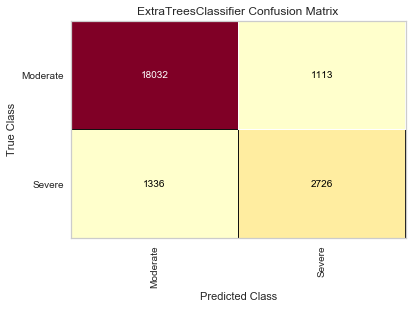

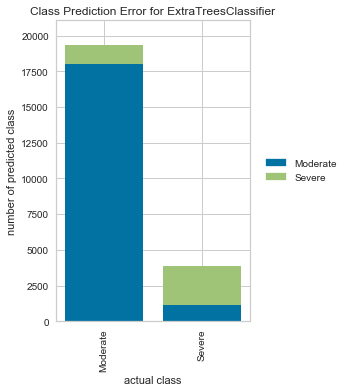

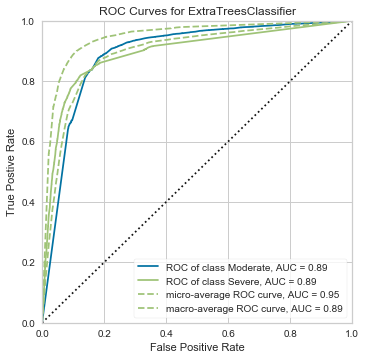

In [47]:
print('###### TRAINING SCORES ExtraTrees ######')

#get ET estimator
est = models[0]

#set up model
mod_ET = setup_model(X, y, est)

#save model
cg.save_estimator(mod_ET)

#fit
mod_ET.fit(X_train, y_train)

#show classification report
visualize_model_report(X_train, X_test, y_train, y_test, mod_ET)

test_score(X_test, y_test, mod_ET)
   
#draw confusion report
confusion_matrix_report(X_test, y_test, mod_ET)

#class prediction errors
class_pred_error(X_test, y_test, mod_ET)

#draw roc curve
roc_curve(X_test, y_test, mod_ET)



###  Training Scores for K-NeighborsClassifier 

In [ ]:
''' Cut to save time
print('###### TRAINING SCORES K_Nearest_Classifier ######')
  
#get ET estimator
est = models[2]

#set up model
mod_KNC = setup_model(X, y, est)


#fit
mod_KNC.fit(X_train, y_train)

#save model
cg.save_estimator(mod_KNC)

#show classification report
visualize_model_report(X_train, X_test, y_train, y_test,mod_KNC)

test_score(X_test, y_test, mod_KNC)
   
#draw confusion report
confusion_matrix_report(X_test, y_test, mod_KNC)

#class prediction errors
class_pred_error(X_test, y_test, mod_KNC)

#draw roc curve
roc_curve(X_test, y_test, mod_KNC)

'''


### Load Test Data 

In [51]:
df_test = pd.read_csv('data/test.csv').sample(27505)
X2, y2 = find_X_y(df_test)

### Setup training data

In [52]:
# Create the train and test data
X_train2, X_test2, y_train2, y_test2 = tts(X2, y2, test_size=0.2)


### EXTRA TREES CLASSIFIERS TEST DATA SCORE

Classifiers perform similar against real data
recall and pricison dropped a bit on Severe because of 
non smote data.

###### TESTING SCORES ExtraTrees ######


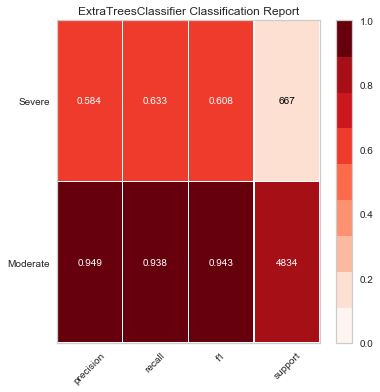


Pipeline : Original data F1 Micro Score : 0.9009271041628795
Pipeline : Original data F2 Macro Score : 0.7754686646809648
              precision    recall  f1-score   support

    Moderate       0.95      0.94      0.94      4834
      Severe       0.58      0.63      0.61       667

    accuracy                           0.90      5501
   macro avg       0.77      0.79      0.78      5501
weighted avg       0.90      0.90      0.90      5501



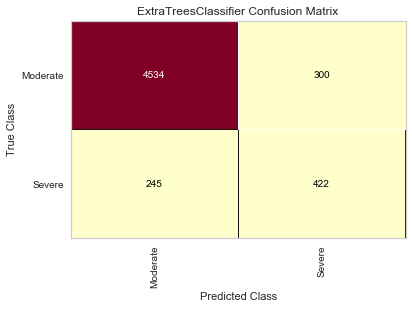

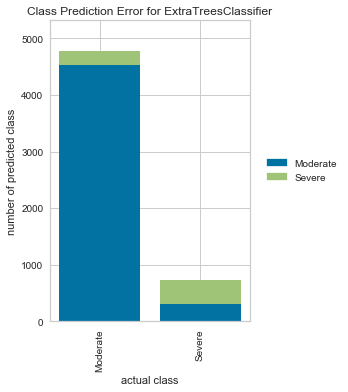

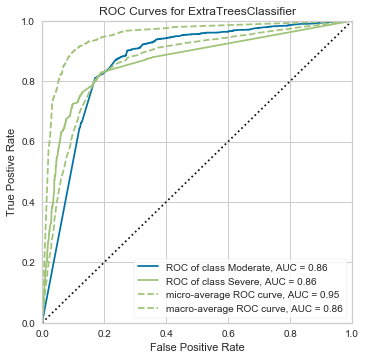

In [54]:
print('###### TESTING SCORES ExtraTrees ######')

#show classification report
visualize_model_report(X_train2, X_test2, y_train2, y_test2, mod_ET)

test_score(X_test2 , y_test2, mod_ET)

#draw confusion report
confusion_matrix_report(X_test2 , y_test2, mod_ET)

#class prediction errors
class_pred_error(X_test2 , y_test2, mod_ET)

#draw roc curve
roc_curve(X_test2 , y_test2, mod_ET)


### K Neighbors Classifier Test Data Scores

###### TESTING SCORES K Neighbors Classifier ######

Pipeline : Original data F1 Micro Score : 0.8783857480458098
Pipeline : Original data F2 Macro Score : 0.7312980533656988
              precision    recall  f1-score   support

    Moderate       0.94      0.92      0.93      4834
      Severe       0.50      0.57      0.53       667

    accuracy                           0.88      5501
   macro avg       0.72      0.75      0.73      5501
weighted avg       0.89      0.88      0.88      5501



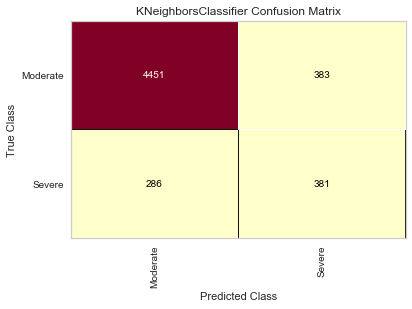

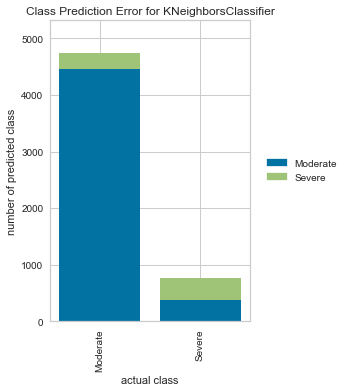

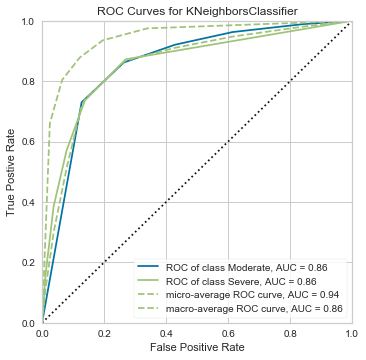

In [55]:
print('###### TESTING SCORES K Neighbors Classifier ######')

#show classification report
#visualize_model_report(X_train2, X_test2, y_train2, y_test2, mod_KNC)

test_score(X_test2 , y_test2,  mod_KNC)

#draw confusion report
confusion_matrix_report(X_test2 , y_test2, mod_KNC)

#class prediction errors
class_pred_error(X_test2 , y_test2, mod_KNC)

#draw roc curve
roc_curve(X_test2 , y_test2,  mod_KNC)


### Final Summary
ExtraTreesClassifier and RandomForestClassifiers performance was equal. KNeighbors was equal as well in predicting 
moderate fires based on precision and recall. ExtraTrees was slightly better in precision and recall for severe fires.
The difference was minor, and in most cases kNeighbors would be chosen over the more complex ensemble alogrithms. 
However the impact of 1 or 2 severe wildfires could be very high so a reasonable case can be made to employ ExtraTrees.

Final conclusion use ExtraTrees since it has a higher recall on severe fires which is our major concern. 


